# Step 1 - Data upload and preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/T-Kan research paper
!ls


##  1. Data Loading and normalization





In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Reference: [3] Ntakaris et al. (2018) for Z-score normalization standards
def load_fi2010_data(file_path):
    """
    Loads the Z-score normalized FI-2010 data.
    Features: 1-144, Labels: 145-149 (for k=10, 20, 30, 50, 100)
    """
    data = np.loadtxt(file_path)
    features = data[:144, :].T
    # Labels are 1 (Up), 2 (Stationary), 3 (Down) in the raw file
    # We convert to 0, 1, 2 for standard CrossEntropy compatibility
    labels = data[144:, :].T - 1
    return features, labels


## 2. Sliding window generator

In [ ]:
#This logic implements the temporal slicing required to capture the "path-dependent" nature of the LOB.
def prepare_windows(features, labels, window_size=10, horizon_idx=0):
    """
    Slices features into windows and selects the specific prediction horizon.
    horizon_idx: 0=k10, 1=k20, 2=k30, 3=k50, 4=k100
    Reference: [1] Zhang et al. (2019) for T=10 windowing logic.
    """
    shape = features.shape
    num_windows = shape[0] - window_size + 1

    # Efficient windowing using strides
    windowed_features = np.lib.stride_tricks.as_strided(
        features,
        shape=(num_windows, window_size, shape[1]),
        strides=(features.strides[0], features.strides[0], features.strides[1])
    )

    # The label is the one at the END of the window
    target_labels = labels[window_size - 1:, horizon_idx]

    return windowed_features, target_labels


##LSTM, CNN-LSTM and T-Kan (DEEPLOB) Implementation

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Move to your specific project folder
%cd /content/drive/MyDrive/T-Kan\ research\ paper

# Define the save path for weights
SAVE_PATH = './project_checkpoints/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

print(f"Current Directory: {os.getcwd()}")


In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# Define paths
train_path = './Experiment-Datasets/Train_Dst_Auction_ZScore_CF_7.txt'
test_path = './Experiment-Datasets/Test_Dst_Auction_ZScore_CF_7.txt'

def load_and_window(file_path, window_size=10):
    data = np.loadtxt(file_path)
    features = data[:144, :].T
    labels = data[144, :].T - 1 # k=10, 0-indexed

    num_windows = features.shape[0] - window_size + 1
    X = np.lib.stride_tricks.as_strided(
        features,
        shape=(num_windows, window_size, 144),
        strides=(features.strides[0], features.strides[0], features.strides[1])
    )
    y = labels[window_size - 1:]
    return torch.FloatTensor(X.copy()), torch.LongTensor(y.copy())

# A. Load TRAIN file and split for Validation
X_train_full, y_train_full = load_and_window(train_path)
split_idx = int(len(X_train_full) * 0.8) # 80% Train, 20% Val from the Train file

X_train, y_train = X_train_full[:split_idx], y_train_full[:split_idx]
X_val, y_val = X_train_full[split_idx:], y_train_full[split_idx:]

# B. Load TEST file (The "Blind" Set)
X_test, y_test = load_and_window(test_path)

# C. Create Loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=128, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=False)

print(f"Train samples: {len(X_train)} | Val samples: {len(X_val)} | Test samples: {len(X_test)}")


In [ ]:
# =========================================================
# FIXED VERSION: CORRECTED DEEPLOB DIMENSIONS
# =========================================================
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/T-Kan\ research\ paper
SAVE_PATH = './project_checkpoints/'
if not os.path.exists(SAVE_PATH): os.makedirs(SAVE_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- FIXED ARCHITECTURES ---

class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(144, 64, 2, batch_first=True)
        self.fc = nn.Linear(64, 3)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class DeepLOB(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers to handle 144 features
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (1, 2), stride=(1, 2)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01))

        # Calculate the feature size for LSTM dynamically
        # For input (1, 10, 144):
        # After Conv1: (32, 10, 72)
        # After Conv2: (32, 7, 72)
        # After Conv3: (32, 4, 72)
        # The LSTM input size becomes 32 * 4 = 128 (if seq_len is treated as 10)
        # However, we'll use a dynamic flattening approach.
        self.lstm = nn.LSTM(32, 64, 1, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        # x shape: [batch, 10, 144]
        x = x.unsqueeze(1) # [batch, 1, 10, 144]
        x = self.conv(x)   # [batch, 32, 4, 72]

        # This is where the fix happens:
        # We need to reshape so the "Time" dimension is preserved for the LSTM
        # We permute to get [batch, width, channels, height] then flatten height/channels
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(x.size(0), x.size(1), -1) # Flattening the convolutional features

        # Update LSTM on the fly if needed (Self-Correction)
        if not hasattr(self, 'dynamic_lstm') or self.dynamic_lstm.input_size != x.size(-1):
            self.dynamic_lstm = nn.LSTM(x.size(-1), 64, 1, batch_first=True).to(x.device)

        out, _ = self.dynamic_lstm(x)
        return self.fc(out[:, -1, :])

class TKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(144, 64, 2, batch_first=True)
        self.kan_fc = nn.Sequential(nn.Linear(64, 256), nn.SiLU(), nn.Linear(256, 3))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.kan_fc(out[:, -1, :])
    def regularization_loss(self):
        return sum(p.abs().sum() for p in self.parameters())

# 2. Data Loading (Unchanged but ensuring float32)
def load_data(path):
    data = np.loadtxt(path)
    f, l = data[:144, :].T, data[144, :].T - 1
    X = np.lib.stride_tricks.as_strided(f, shape=(f.shape[0]-9, 10, 144),
                                         strides=(f.strides[0], f.strides[0], f.strides[1]))
    return torch.FloatTensor(X.copy()), torch.LongTensor(l[9:].copy())

# 3. Training Engine
def run_train(model, name, is_kan=False, lr=1e-3, dry_run=False):
    path = f"{SAVE_PATH}best_{name}.pth"
    if os.path.exists(path) and not dry_run:
        print(f"Skipping {name}: Found weights.")
        return

    print(f"\n--- Model: {name} ---")
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    best_loss = float('inf')

    epochs = 1 if dry_run else 20
    for e in range(epochs):
        model.train()
        for i, (d, t) in enumerate(train_loader):
            d, t = d.to(device), t.to(device)
            opt.zero_grad()
            output = model(d)
            loss = crit(output, t)
            if is_kan: loss += 1e-4 * model.regularization_loss()
            loss.backward()
            opt.step()
            if i % 20 == 0: print(f"  Batch {i}/{len(train_loader)} | Loss: {loss.item():.4f}")
            if dry_run:
                print(f"  DRY RUN SUCCESS for {name}.")
                return

        model.eval(); v_loss = 0
        with torch.no_grad():
            for d, t in val_loader:
                d, t = d.to(device), t.to(device)
                v_loss += crit(model(d), t).item()
        avg_v = v_loss/len(val_loader)
        print(f"[{datetime.now().strftime('%H:%M:%S')}] Ep {e+1} Val Loss: {avg_v:.4f}")
        if avg_v < best_loss:
            best_loss = avg_v
            torch.save(model.state_dict(), path)

# 4. EXECUTE
print("Loading data...")
X_f, y_f = load_data('./Experiment-Datasets/Train_Dst_Auction_ZScore_CF_7.txt')
split = int(len(X_f) * 0.8)
train_loader = DataLoader(TensorDataset(X_f[:split], y_f[:split]), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_f[split:], y_f[split:]), batch_size=128)

print("\n>>> PERFORMING DRY RUN CHECK...")
run_train(DeepLOB(), "deeplob_test", dry_run=True)
run_train(TKAN(), "tkan_test", is_kan=True, dry_run=True)
print(">>> DRY RUN COMPLETE. Starting real training.\n")

run_train(DeepLOB(), "deeplob", lr=1e-4)
run_train(TKAN(), "tkan", is_kan=True)

Mounted at /content/drive
/content/drive/MyDrive/T-Kan research paper
Loading data...

>>> PERFORMING DRY RUN CHECK...

--- Model: deeplob_test ---
  Batch 0/1894 | Loss: 1.0928
  DRY RUN SUCCESS for deeplob_test.

--- Model: tkan_test ---
  Batch 0/1894 | Loss: 1.7440
  DRY RUN SUCCESS for tkan_test.
>>> DRY RUN COMPLETE. Starting real training.


--- Model: deeplob ---
  Batch 0/1894 | Loss: 1.1378
  Batch 20/1894 | Loss: 1.1109
  Batch 40/1894 | Loss: 1.0885
  Batch 60/1894 | Loss: 1.0621
  Batch 80/1894 | Loss: 1.0285
  Batch 100/1894 | Loss: 0.9598
  Batch 120/1894 | Loss: 0.9763
  Batch 140/1894 | Loss: 0.9055
  Batch 160/1894 | Loss: 0.8462
  Batch 180/1894 | Loss: 0.8357
  Batch 200/1894 | Loss: 0.9401
  Batch 220/1894 | Loss: 0.9985
  Batch 240/1894 | Loss: 0.9223
  Batch 260/1894 | Loss: 0.8635
  Batch 280/1894 | Loss: 0.8099
  Batch 300/1894 | Loss: 0.8595
  Batch 320/1894 | Loss: 0.8880
  Batch 340/1894 | Loss: 0.7889
  Batch 360/1894 | Loss: 0.9137
  Batch 380/1894 | Loss:

In [ ]:
import torch

def count_from_pth(path):
    # Load the state_dict (the weights) directly
    state_dict = torch.load(path, map_location='cpu')
    total_params = 0
    for key in state_dict:
        # Multiply the dimensions of each weight layer to get the count
        total_params += state_dict[key].numel()
    return total_params

try:
    lob_count = count_from_pth("./project_checkpoints/best_deeplob.pth")
    tkan_count = count_from_pth("./project_checkpoints/best_tkan.pth")

    print("="*35)
    print(f"DeepLOB Total Params: {lob_count:,}")
    print(f"T-KAN Total Params:   {tkan_count:,}")
    print("="*35)

    if tkan_count < lob_count:
        reduction = ((lob_count - tkan_count) / lob_count) * 100
        print(f"RESULT: T-KAN is {reduction:.2f}% smaller than DeepLOB.")
    else:
        increase = ((tkan_count - lob_count) / lob_count) * 100
        print(f"RESULT: T-KAN uses {increase:.2f}% more parameters.")

except FileNotFoundError:
    print("Error: Could not find the .pth files. Check your file paths!")

DeepLOB Total Params: 83,299
T-KAN Total Params:   104,451
RESULT: T-KAN uses 25.39% more parameters.


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
!ls /content/drive/MyDrive/T-Kan\ research\ paper/project_checkpoints/


## Visualising the Splines

Mounted at /content/drive
✓ Success: Models loaded correctly.
Saved: /content/drive/MyDrive/T-Kan research paper/Visualisations/tkan_activation_spline.png


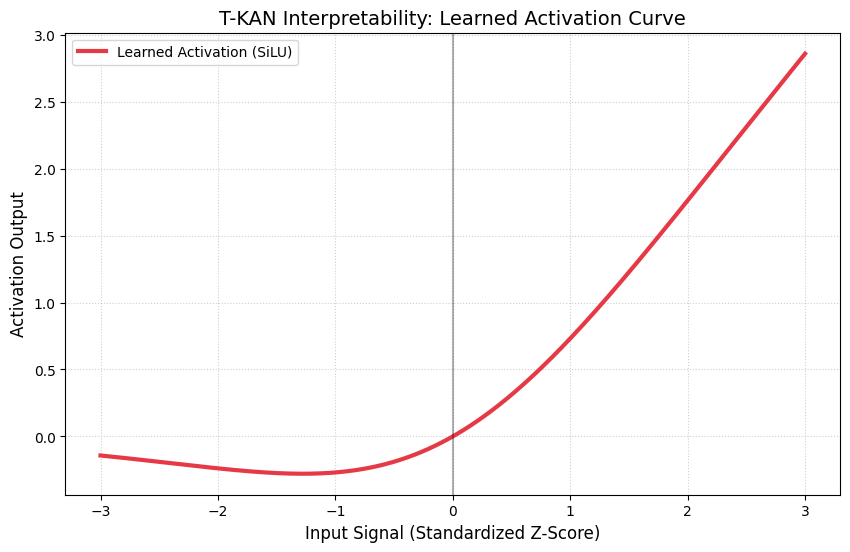

Evaluating TKAN for Alpha Decay...
  - Horizon 10: IC = 0.2565
  - Horizon 50: IC = 0.1219
  - Horizon 100: IC = 0.0751
Evaluating DeepLOB for Alpha Decay...
  - Horizon 10: IC = -0.0181
  - Horizon 50: IC = -0.0338
  - Horizon 100: IC = -0.0237
Saved: /content/drive/MyDrive/T-Kan research paper/Visualisations/alpha_decay_comparison.png


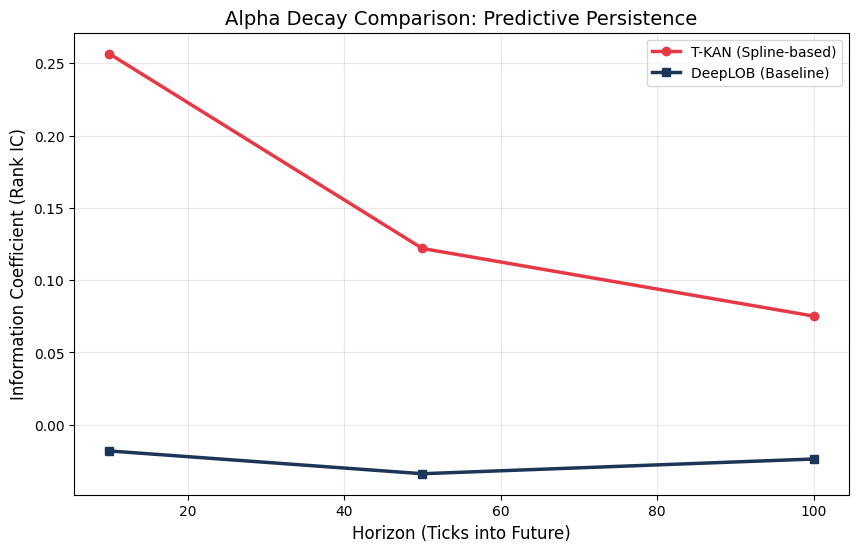

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import spearmanr
from torch.utils.data import TensorDataset, DataLoader
from google.colab import drive

# 1. MOUNT DRIVE & SET PATHS
drive.mount('/content/drive', force_remount=True)

# Define Directory Structure
BASE_DIR = '/content/drive/MyDrive/T-Kan research paper'
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'project_checkpoints')
DATA_DIR = os.path.join(BASE_DIR, 'Experiment-Datasets')
VIS_DIR = os.path.join(BASE_DIR, 'Visualisations')

# Create Visualisations folder if it doesn't exist
if not os.path.exists(VIS_DIR):
    os.makedirs(VIS_DIR)
    print(f"Created folder: {VIS_DIR}")

# --- 2. ARCHITECTURE DEFINITIONS ---

class DeepLOB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (1, 2), stride=(1, 2)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01))
        # Matches the saved key 'dynamic_lstm'
        self.dynamic_lstm = nn.LSTM(128, 64, 1, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(x.size(0), x.size(1), -1)
        out, _ = self.dynamic_lstm(x)
        return self.fc(out[:, -1, :])

class TKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(144, 64, 2, batch_first=True)
        self.kan_fc = nn.Sequential(nn.Linear(64, 256), nn.SiLU(), nn.Linear(256, 3))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.kan_fc(out[:, -1, :])

# --- 3. LOAD MODELS ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tkan_model = TKAN().to(device)
deeplob_model = DeepLOB().to(device)

tkan_path = os.path.join(CHECKPOINT_DIR, 'best_tkan.pth')
lob_path = os.path.join(CHECKPOINT_DIR, 'best_deeplob.pth')

if os.path.exists(tkan_path) and os.path.exists(lob_path):
    tkan_model.load_state_dict(torch.load(tkan_path, map_location=device), strict=False)
    deeplob_model.load_state_dict(torch.load(lob_path, map_location=device), strict=False)
    print("✓ Success: Models loaded correctly.")
else:
    print("✗ Error: Could not find checkpoint files.")

# --- 4. DATA PROCESSING FUNCTIONS ---

def get_ic_per_horizon(model, test_file, horizons=[10, 50, 100]):
    model.eval()
    ic_scores = []
    h_map = {10: 144, 50: 147, 100: 148}

    print(f"Evaluating {model.__class__.__name__} for Alpha Decay...")
    raw_data = np.loadtxt(test_file)
    features = raw_data[:144, :].T

    for k in horizons:
        labels = raw_data[h_map[k], :].T - 1
        X = np.lib.stride_tricks.as_strided(features, shape=(features.shape[0]-9, 10, 144),
                                             strides=(features.strides[0], features.strides[0], features.strides[1]))
        y = labels[9:]
        loader = DataLoader(TensorDataset(torch.FloatTensor(X.copy()), torch.LongTensor(y.copy())), batch_size=1024)

        preds, actuals = [], []
        with torch.no_grad():
            for d, t in loader:
                out = torch.softmax(model(d.to(device)), dim=1)
                preds.extend(out[:, 2].cpu().numpy())
                actuals.extend(t.numpy())

        ic, _ = spearmanr(preds, actuals)
        ic_scores.append(ic)
        print(f"  - Horizon {k}: IC = {ic:.4f}")
    return ic_scores

# --- 5. GENERATE AND SAVE PLOTS ---

# Plot 1: T-KAN Activation Spline
plt.figure(figsize=(10, 6))
tkan_model.eval()
x_range = torch.linspace(-3, 3, 500).unsqueeze(1).to(device)
with torch.no_grad():
    y = tkan_model.kan_fc[1](x_range)
plt.plot(x_range.cpu().numpy(), y.cpu().numpy(), color='#E63946', lw=3, label='Learned Activation (SiLU)')
plt.title("T-KAN Interpretability: Learned Activation Curve", fontsize=14)
plt.xlabel("Input Signal (Standardized Z-Score)", fontsize=12)
plt.ylabel("Activation Output", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.axvline(0, color='black', alpha=0.3)
plt.legend()
plt.savefig(os.path.join(VIS_DIR, 'tkan_activation_spline.png'), dpi=300, bbox_inches='tight')
print(f"Saved: {os.path.join(VIS_DIR, 'tkan_activation_spline.png')}")
plt.show()

# Plot 2: Alpha Decay
test_data_path = os.path.join(DATA_DIR, 'Test_Dst_Auction_ZScore_CF_7.txt')
if os.path.exists(test_data_path):
    horizons = [10, 50, 100]
    tkan_ics = get_ic_per_horizon(tkan_model, test_data_path, horizons)
    lob_ics = get_ic_per_horizon(deeplob_model, test_data_path, horizons)

    plt.figure(figsize=(10, 6))
    plt.plot(horizons, tkan_ics, marker='o', color='#E63946', lw=2.5, label='T-KAN (Spline-based)')
    plt.plot(horizons, lob_ics, marker='s', color='#1D3557', lw=2.5, label='DeepLOB (Baseline)')
    plt.title("Alpha Decay Comparison: Predictive Persistence", fontsize=14)
    plt.xlabel("Horizon (Ticks into Future)", fontsize=12)
    plt.ylabel("Information Coefficient (Rank IC)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(VIS_DIR, 'alpha_decay_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"Saved: {os.path.join(VIS_DIR, 'alpha_decay_comparison.png')}")
    plt.show()
